In [107]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2
import time 
import matplotlib.pyplot as plt


In [63]:
# Hyperparameters
EPISODES = 1000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
GAMMA = 0.99
LR = 0.0001
BATCH_SIZE = 32
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
DEVICE = torch.device("cpu")

In [64]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state, dtype=np.float32), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state, dtype=np.float32), np.array(done, dtype=np.float32)
        
    def __len__(self):
        return len(self.buffer)

In [65]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.net(x)

In [76]:
def train(env,policy_net, target_net):
    # policy_net = DQN(input_shape, num_actions).to(DEVICE)
    # target_net = DQN(input_shape, num_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer(MEMORY_SIZE)
    
    epsilon = EPSILON_START
    episode_rewards = []
    
    for episode in range(EPISODES):
        state,_ = env.reset()
        total_reward = 0
        
        for t in range(1, 10000):
            if random.random() > epsilon:
                with torch.no_grad():
                    action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(DEVICE)).argmax().item()
            else:
                action = env.action_space.sample()
            next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else env.step(action) + (False,)
            done = done or truncated
            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break
            
            if len(memory) > BATCH_SIZE:
                states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)
                
                states = torch.FloatTensor(states).to(DEVICE)
                actions = torch.LongTensor(actions).to(DEVICE)
                rewards = torch.FloatTensor(rewards).to(DEVICE)
                next_states = torch.FloatTensor(next_states).to(DEVICE)
                dones = torch.FloatTensor(dones).to(DEVICE)
                
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(next_states).max(1)[0]
                expected_q_values = rewards + GAMMA * next_q_values * (1 - dones)
                
                loss = nn.MSELoss()(q_values, expected_q_values.detach())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        episode_rewards.append(total_reward)
        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        
        if episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon}")
    
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()


In [94]:
def evaluate(env, policy_net, episodes=10):
    policy_net.eval()
    total_rewards = []

    for episode in range(episodes):
        state, _ = env.reset()

        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(DEVICE)).argmax().item()
                next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else env.step(action) + (False,)

            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode}, Total Reward: {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward}")


In [78]:
def make_env():
    env = gym.make('CartPole-v1')
    # state = env.reset()
    # print(state)
    # action = env.action_space.sample()
    # next_state, reward, done, truncated, _ = env.step(action) if len(env.step(action)) == 5 else env.step(action) + (False,)
    # me = env.step(action)
    # print(me)
    # print(next_state)
    # print(reward)
    # print(done)
    # print(truncated)
    # state = env.reset()
    return env

Episode 0, Total Reward: 7.0, Epsilon: 0.995
Episode 1, Total Reward: 6.0, Epsilon: 0.990025
Episode 2, Total Reward: 6.0, Epsilon: 0.985074875
Episode 3, Total Reward: 7.0, Epsilon: 0.9801495006250001
Episode 4, Total Reward: 12.0, Epsilon: 0.9752487531218751
Episode 5, Total Reward: 5.0, Epsilon: 0.9703725093562657
Episode 6, Total Reward: 8.0, Epsilon: 0.9655206468094844
Episode 7, Total Reward: 8.0, Epsilon: 0.960693043575437
Episode 8, Total Reward: 32.0, Epsilon: 0.9558895783575597
Episode 9, Total Reward: 7.0, Epsilon: 0.9511101304657719
Episode 10, Total Reward: 9.0, Epsilon: 0.946354579813443
Episode 11, Total Reward: 4.0, Epsilon: 0.9416228069143757
Episode 12, Total Reward: 5.0, Epsilon: 0.9369146928798039
Episode 13, Total Reward: 5.0, Epsilon: 0.9322301194154049
Episode 14, Total Reward: 9.0, Epsilon: 0.9275689688183278
Episode 15, Total Reward: 6.0, Epsilon: 0.9229311239742362
Episode 16, Total Reward: 8.0, Epsilon: 0.918316468354365
Episode 17, Total Reward: 5.0, Epsilon

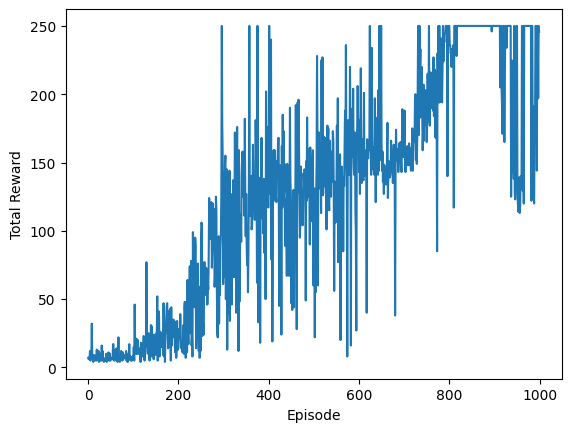

Evaluation Episode 0, Total Reward: 191.0
Evaluation Episode 1, Total Reward: 364.0
Evaluation Episode 2, Total Reward: 220.0
Evaluation Episode 3, Total Reward: 186.0
Evaluation Episode 4, Total Reward: 172.0
Evaluation Episode 5, Total Reward: 219.0
Evaluation Episode 6, Total Reward: 212.0
Evaluation Episode 7, Total Reward: 198.0
Evaluation Episode 8, Total Reward: 195.0
Evaluation Episode 9, Total Reward: 218.0
Average Reward over 10 episodes: 217.5


In [103]:
if __name__ == "__main__":
    env = make_env()
    input_shape = (env.observation_space.shape[0],)
    num_actions = env.action_space.n
    
    policy_net = DQN(input_shape, num_actions).to(DEVICE)
    target_net = DQN(input_shape, num_actions).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    
    train(env, policy_net, target_net)
    evaluate(env, policy_net)

In [104]:
evaluate(env, policy_net)

Evaluation Episode 0, Total Reward: 209.0
Evaluation Episode 1, Total Reward: 181.0
Evaluation Episode 2, Total Reward: 209.0
Evaluation Episode 3, Total Reward: 155.0
Evaluation Episode 4, Total Reward: 181.0
Evaluation Episode 5, Total Reward: 300.0
Evaluation Episode 6, Total Reward: 223.0
Evaluation Episode 7, Total Reward: 204.0
Evaluation Episode 8, Total Reward: 190.0
Evaluation Episode 9, Total Reward: 196.0
Average Reward over 10 episodes: 204.8


In [105]:
! pip3 install 'gym[box2d]'

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using Darwin configuration...
      
      /bin/sh: pkg-config: command not found
      /bin/sh: pkg-config: command not found
      /bin/sh: pkg-config: command not found
      
      ---
      For help with compilation see:
          https://www.pygame.org/wiki/MacCompile
      To contribute to pygame development see:
          https://www.pygame.org/contribute.html
      ---
      
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/sk/g878drq92n50q03b657sw1p

In [106]:
! pip3 install 'gym[atari]'

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached gym-0.26.1.tar.gz (719 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.26.0.tar.gz (710 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.25.2.tar.gz (734 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.25.1.tar.gz (732 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.25.0.tar.gz (720 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing met